<a href="https://colab.research.google.com/github/andrewng88/Deep-Learning/blob/master/11_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/gdrive/
/content/gdrive/My Drive/Colab Notebooks
Files already downloaded and verified
Files already downloaded and verified


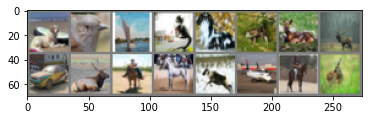

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

# change directory 
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/
# assert directory
%pwd

# Hyper-parameters 
num_epochs = 50
batch_size = 16
learning_rate = 1e-3


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                           train=True, 
                                           transform=transform,  
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                          train=False, 
                                          transform=transform,
                                          download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))



In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # input torch.Size([4,3,32,32]) batch, rgb, w ,h
        self.conv1 = nn.Conv2d(3,6,5) #input_size,output_size,kernel_size
        # torch.Size([4,6(inherit from CNN output),28,28])
        #( ( W - F + 2P ) / S )+ 1
        #  32- 5 / 1 + 1 = 28

        self.pool =  nn.MaxPool2d(2,2) #kernel_size,stride
        # torch.Size([4,6(output),14,14]) #reduce by a factor of 2

        self.conv2 = nn.Conv2d(6,16,5) #input_size=prev_output_size,output_size,kernel_size
        # torch.Size([4,16,10,10]) 
        #( (14 - 5)/1 )+ 1 = 10

        # applied automatically by Pytorch
        # self.pool =  nn.MaxPool2d(2,2) #kernel_size,stride
        # torch.Size([4,16(output),5,5]) #reduce by a factor of 2

        # convert to single vector torch.Size([4,16*5*5])
        self.fc1 = nn.Linear(16*5*5,120) #16*5*5 = fixed

        self.fc2 = nn.Linear(120,84) # the rest in between can vary
        self.fc3 = nn.Linear(84,10) #10 = fixec

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #activation doesn't change size
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #no activation required because of nn.CrossEntropyLoss()
        return x

model = ConvNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [4, 3, 32, 32] = 8, 3 , 1024
        # input_layer = 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('\nTraining completed\n')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]


    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Epoch [1/50], Step [2000/3125], Loss: 1.7000
Epoch [2/50], Step [2000/3125], Loss: 0.8538
Epoch [3/50], Step [2000/3125], Loss: 1.0368
Epoch [4/50], Step [2000/3125], Loss: 1.1293
Epoch [5/50], Step [2000/3125], Loss: 1.0421
Epoch [6/50], Step [2000/3125], Loss: 0.9374
Epoch [7/50], Step [2000/3125], Loss: 0.7097
Epoch [8/50], Step [2000/3125], Loss: 0.9294
Epoch [9/50], Step [2000/3125], Loss: 0.6269
Epoch [10/50], Step [2000/3125], Loss: 1.1711
Epoch [11/50], Step [2000/3125], Loss: 0.9964
Epoch [12/50], Step [2000/3125], Loss: 0.7133
Epoch [13/50], Step [2000/3125], Loss: 0.3961
Epoch [14/50], Step [2000/3125], Loss: 0.7553
Epoch [15/50], Step [2000/3125], Loss: 0.6961
Epoch [16/50], Step [2000/3125], Loss: 0.5836
Epoch [17/50], Step [2000/3125], Loss: 0.7254
Epoch [18/50], Step [2000/3125], Loss: 0.8570
Epoch [19/50], Step [2000/3125], Loss: 0.4314
Epoch [20/50], Step [2000/3125], Loss: 0.4507
Epoch [21/50], Step [2000/3125], Loss: 1.0404
Epoch [22/50], Step [2000/3125], Loss: 0.82